# Task 4 Modeling&Evaluation

Sub-Task 1:Build churn model(s) to try to predict the churn probability of any customer.

Sub-Task 2:Evaluate your model, using a holdout set, and with metrics of your choosing.

Sub-Task 3:Interpret the results and use them to formulate answers to the client’s hypotheses and questions. 

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(color_codes=True)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Load Data 

In [2]:
df=pd.read_csv("feature_engineering.csv")   
df.head()

,forecast_discount_energy,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,churn,contract_duration,activ_diff,end_diff,modif_diff,renewal_diff,channel_sales_epum,channel_sales_ewpa,channel_sales_fixd,channel_sales_foos,channel_sales_lmke,channel_sales_sddi,channel_sales_usil,origin_up_ewxe,origin_up_kamk,origin_up_ldks,origin_up_lxid,origin_up_usap,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3
0,0.0,0.095919,0.088347,58.995952,0,22.462276,21.460318,1,1732.36,180.000,0,47,37,-10,37,1,0,0,0,0,1,0,0,0,0,1,0,0,12.641989,0.000000,9.212937,10.185703,9.212937,5.886909,6.724794,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,59.059950,36.449002,8.404292,0.099170,0.089992,0.066557,59.055124,36.417705,8.350997,59.154293,36.507697,8.417554
1,0.0,0.114481,0.098142,40.606701,1,25.440000,25.440000,2,678.99,43.648,1,36,30,-5,2,6,0,0,0,1,0,0,0,0,0,0,1,0,0.000000,10.914124,0.000000,0.000000,0.000000,1.022451,0.000000,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,41.067053,22.452760,14.967871,0.131756,0.092638,0.036910,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687
2,0.0,0.145711,0.000000,44.311378,0,16.380000,16.380000,1,18.89,13.800,0,84,76,-7,76,4,0,0,0,0,0,0,0,0,1,0,0,0,8.446985,0.000000,0.000000,5.252012,0.000000,2.848971,0.000000,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,44.460984,0.007124,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000
3,0.0,0.165794,0.087899,44.311378,0,28.600000,28.600000,1,6.60,13.856,0,72,68,-3,68,8,0,0,0,1,0,0,0,0,1,0,0,0,6.300786,0.000000,0.000000,3.891004,0.000000,3.681855,0.000000,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,44.555962,0.088421,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000
4,0.0,0.146694,0.000000,44.311378,0,30.220000,30.220000,1,25.46,13.200,0,72,69,-2,69,9,0,0,0,0,1,0,0,0,1,0,0,0,7.368340,0.000000,0.000000,5.484963,0.000000,3.036394,0.000000,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,44.551475,0.000000,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000


## Splitting data 

In [3]:
#First we need to specify features and target 
y=df['churn']
X=df.drop('churn',axis=1)

In [4]:
#Check the binary target
y.value_counts()

0    14331
1     1528
Name: churn, dtype: int64

As we can see, the y(churn) is imbalanced

In [5]:
#Spliting dataset 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

## Base Models

We are going to quickly test the fit of 6 different models 
* Logistic Regression: basic linear classifier (good to baseline)
* Random Forest: ensemble bagging classifier
* K-Nearest Neighbors: instance based classifier
* Support Vector Machines: maximum margin classifier
* Gaussian Naive Bayes: probabilistic classifier
* XGBoost: ensemble (extreme!) boosting classifier

In [6]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB 
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs=[]
    models =[('LogReg', LogisticRegression()), 
        ('RF', RandomForestClassifier ()),
        ('KNN', KNeighborsClassifier ()),
        ('SVM', SVC()), 
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier(eval_metric='mlogloss'))
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['malignant', 'benign']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

In [7]:
run_exps(X_train,y_train,X_test,y_test)

LogReg
              precision    recall  f1-score   support

   malignant       0.91      1.00      0.95      2871
      benign       0.33      0.00      0.01       301

    accuracy                           0.90      3172
   macro avg       0.62      0.50      0.48      3172
weighted avg       0.85      0.90      0.86      3172

RF
              precision    recall  f1-score   support

   malignant       0.91      1.00      0.95      2871
      benign       0.76      0.05      0.10       301

    accuracy                           0.91      3172
   macro avg       0.84      0.53      0.53      3172
weighted avg       0.90      0.91      0.87      3172

KNN
              precision    recall  f1-score   support

   malignant       0.91      0.99      0.95      2871
      benign       0.22      0.03      0.05       301

    accuracy                           0.90      3172
   macro avg       0.56      0.51      0.50      3172
weighted avg       0.84      0.90      0.86      3172

SVM
 

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.181278,0.015472,0.895193,0.801371,0.895193,0.845688,0.627590,LogReg
1,0.112731,0.009289,0.906225,0.853343,0.906225,0.862779,0.600856,LogReg
2,0.107510,0.008401,0.911313,0.831177,0.911313,0.869402,0.645079,LogReg
3,0.113473,0.009013,0.895546,0.824947,0.895546,0.848067,0.590920,LogReg
4,0.106269,0.008844,0.905400,0.844854,0.905400,0.861954,0.601032,LogReg
5,2.445273,0.100206,0.899921,0.893368,0.899921,0.858815,0.713295,RF
6,2.435634,0.099173,0.910165,0.893356,0.910165,0.874574,0.694917,RF
7,2.356782,0.124688,0.914466,0.899455,0.914466,0.878916,0.689458,RF
8,2.648319,0.105518,0.900670,0.902254,0.900670,0.857942,0.656134,RF
9,2.366336,0.097486,0.908159,0.891904,0.908159,0.868456,0.680712,RF


In [8]:
final=run_exps(X_train,y_train,X_test,y_test)
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model==model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

LogReg
              precision    recall  f1-score   support

   malignant       0.91      1.00      0.95      2871
      benign       0.33      0.00      0.01       301

    accuracy                           0.90      3172
   macro avg       0.62      0.50      0.48      3172
weighted avg       0.85      0.90      0.86      3172

RF
              precision    recall  f1-score   support

   malignant       0.91      1.00      0.95      2871
      benign       0.86      0.06      0.11       301

    accuracy                           0.91      3172
   macro avg       0.88      0.53      0.53      3172
weighted avg       0.91      0.91      0.87      3172

KNN
              precision    recall  f1-score   support

   malignant       0.91      0.99      0.95      2871
      benign       0.22      0.03      0.05       301

    accuracy                           0.90      3172
   macro avg       0.56      0.51      0.50      3172
weighted avg       0.84      0.90      0.86      3172

SVM
 

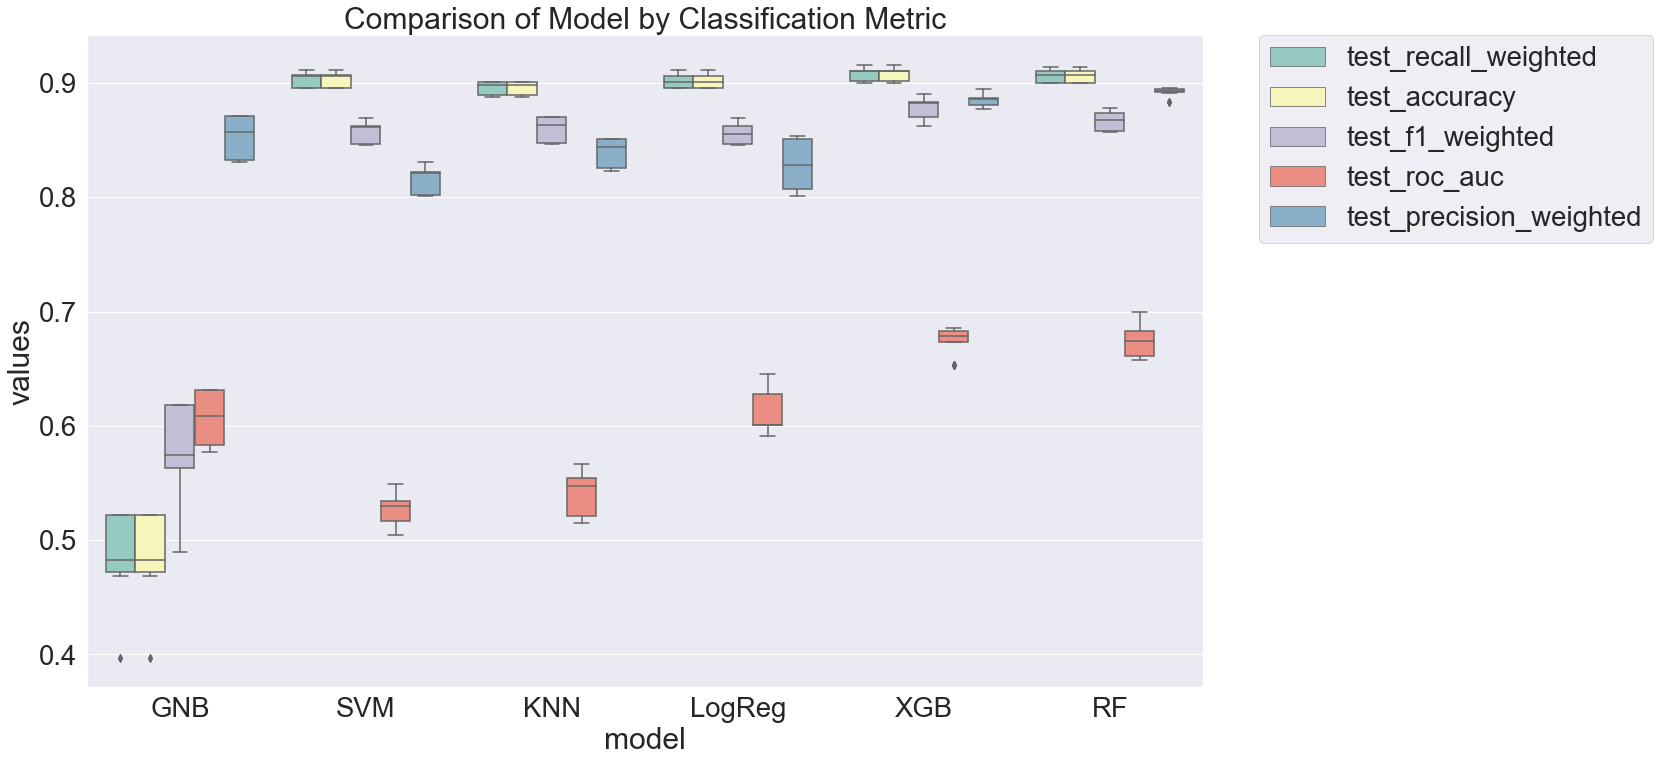

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

It is clearly that GNBs fit our data poorly across alomast all the metrics, and the XGBoost and Random Forest fit the data very well

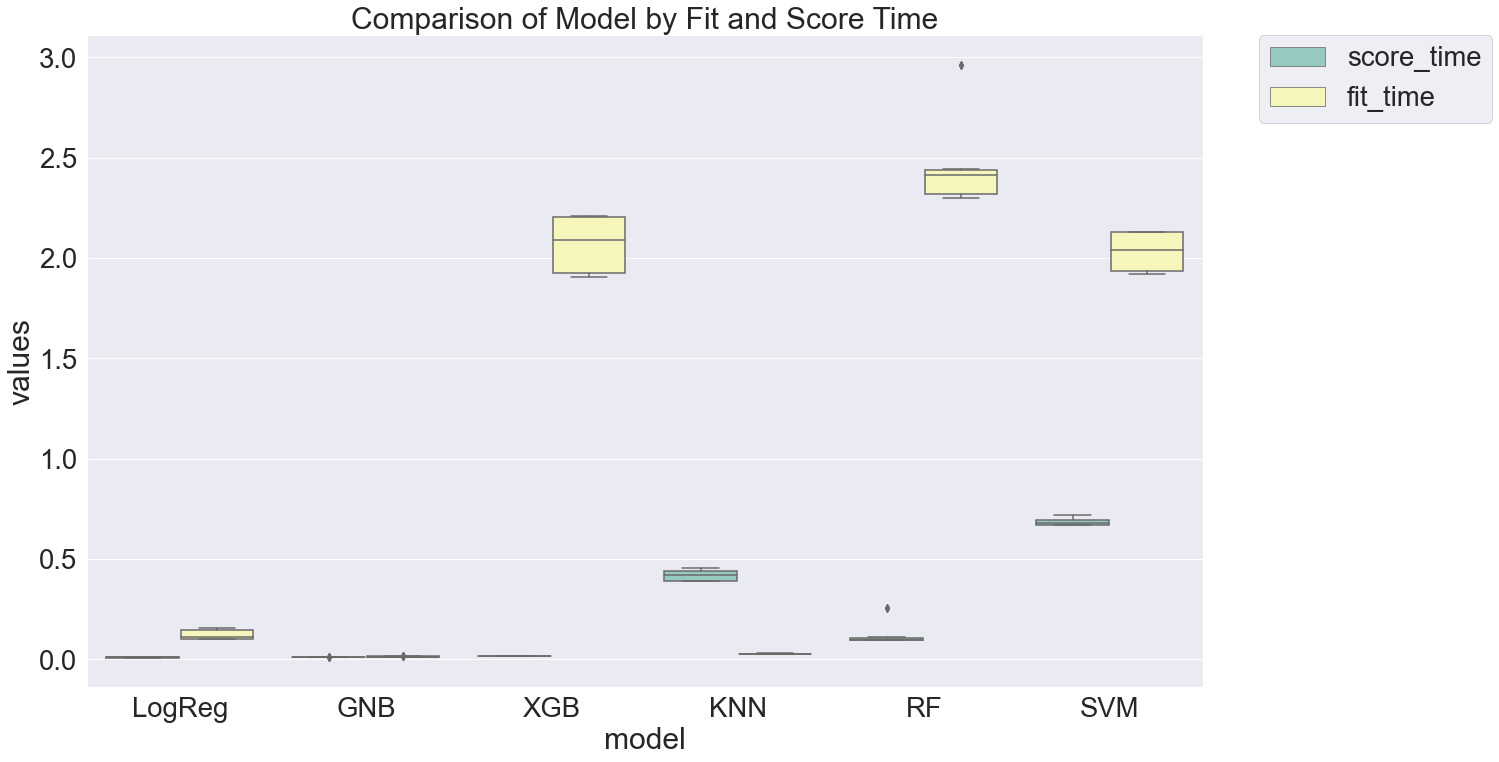

In [10]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

From the figure above we can see that the SVM is slow to train and score,for the Random Forest and XGBoost, the XGBoost has faster fit time

In [11]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_recall_weighted           test_precision_weighted            \
                        std      mean                     std      mean   
model                                                                     
GNB                0.034210  0.492161                0.017498  0.851936   
KNN                0.005488  0.896126                0.011259  0.839678   
LogReg             0.006366  0.901387                0.020117  0.829054   
RF                 0.005747  0.906204                0.003423  0.892445   
SVM                0.006412  0.902569                0.011626  0.814896   
XGB                0.006330  0.907486                0.006454  0.885163   

       test_accuracy           test_f1_weighted           test_roc_auc  \
                 std      mean              std      mean          std   
model                                                                    
GNB         0.034210  0.492161         0.036219  0.585762     0.022127   
KNN         0.005488  0.896126         0.009748  0.860121     0.018207   
LogReg      0.006366  0.901387         0.009245  0.855589     0.019281   
RF          0.005747  0.906204         0.008587  0.867215     0.014398   
SVM         0.006412  0.902569         0.009308  0.856484     0.015840   
XGB         0.006330  0.907486         0.010578  0.877279     0.011672   

                  
            mean  
model             
GNB     0.608337  
KNN     0.543477  
LogReg  0.611581  
RF      0.676356  
SVM     0.527293  
XGB     0.672990

In [12]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

score_time            fit_time          
              std      mean       std      mean
model                                          
GNB      0.000484  0.010654  0.000934  0.014204
KNN      0.022762  0.419944  0.002279  0.027204
LogReg   0.001222  0.009340  0.021929  0.119620
RF       0.048464  0.115296  0.186116  2.437337
SVM      0.019577  0.687027  0.087527  2.035073
XGB      0.000952  0.016685  0.130804  2.075427

Based on the analysis of six models, I will focus on the XGBoost as continue  refining model, not only because it has the best performing but also it has relativily fast train and score time

## Model Finetuning

In [13]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [14]:
#Create the random grid
params={
    'min_child_weight':[i for i in np.arange(1,15,1)],
    'gamma':[i for i in np.arange(0,6,0.5)],
    'subsample':[i for i in np.arange(0,1.1,0.1)],
    'colsample_bytree':[i for i in np.arange(0,1.1,0.1)],
    'max_depth':[i for i in np.arange(1,15,1)],
    'scale_pos_weight':[i for i in np.arange(0,0.15,0.01)],
    'learning_rate':[i for i in np.arange(0,0.15,0.01)],
    'n_estimators':[i for i in np.arange(0,2000,100)],
}

In [15]:
#Create model 
xg=xgb.XGBClassifier(objective='binary:logistic',nthread=1,eval_metric='mlogloss')

In [16]:
#Random search of parameters,using 5
xg_random=RandomizedSearchCV(xg,param_distributions=params,
                            n_iter=1,scoring='roc_auc',
                            n_jobs=4,cv=5,verbose=3,random_state=1001)
xg_random.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.8s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   13.6s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                        'n_estimators': [0, 100, 200, 300, 400,
                                                         500, 600, 700, 800,
                        

In [17]:
best_random=xg_random.best_params_
best_random={'subsample':0.8,
'scale_pos_weight':1,
'n_estimators':1100,
'max_depth':12,
'learning_rate':0.01,
'gamma':4.0,
'colsample_bytree':0.60}

In [18]:
#Create a model with the parameters found
model_random=xgb.XGBClassifier(objective='binary:logistic',
                               nthread=1,eval_metric='mlogloss',**best_random)
                              
fprs,tprs,score=[],[],[]

In [19]:
from sklearn.model_selection import StratifiedKFold
cv=StratifiedKFold(n_splits=5,random_state=13,shuffle=True)

In [20]:
from sklearn import metrics
def compute_roc_auc(model_,index):
    y_predict=model_.predict_proba(X.iloc[index])[:,1]
    fpr,tpr,threholds=metrics.roc_curve(y.iloc[index],y_predict)
    auc_score=metrics.auc(fpr,tpr)
    return fpr,tpr,auc_score

In [21]:
for (train,test), i in zip(cv.split(X,y),range(5)):
    model_random.fit(X.iloc[train],y.iloc[train])
    _,_,auc_score_train=compute_roc_auc(model_random,train)
    fpr,tpr,auc_score=compute_roc_auc(model_random,test)
    score.append((auc_score_train,auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

In [22]:
def plot_roc_curve(fprs,tprs):
    tprs_interp=[]
    aucs=[]
    mean_fpr=np.linspace(0,1,100)
    f,ax=plt.subplots(figsize=(18,10))
    
    for i,(fpr,tpr) in enumerate(zip(fprs,tprs)):
        tprs_interp.append(np.interp(mean_fpr,fpr,tpr))
        tprs_interp[-1][0]=0.0
        roc_auc=metrics.auc(fpr,tpr)
        aucs.append(roc_auc)
        ax.plot(fpr,tpr,lw=2,alpha=0.3,
                label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc))
    plt.plot([0,1],[0,1],linestyle='--',lw=3,color='r',label="Rondom",alpha=.8)
    mean_tpr=np.mean(tprs_interp,axis=0)
    mean_tpr[-1]=1.0
    mean_auc=metrics.auc(mean_fpr,mean_tpr)
    std_auc=np.std(aucs)
    ax.plot(mean_fpr,mean_tpr,color='b',
            label=r"Mean ROC (AUC= %0.2f $\pm$ %0.2f)" % (mean_auc,std_auc),
           lw=4,alpha=.8)
    std_tpr=np.std(tprs_interp,axis=0)
    tprs_upper=np.minimum(mean_tpr+std_tpr,1)
    tprs_lower=np.maximum(mean_tpr-std_tpr,0)
    
    ax.fill_between(mean_fpr,tprs_lower,tprs_upper,color='grey',
                   label=r'$\pm$ 1 std. dev.',alpha=.2)
    ax.set_xlim([-0.05,1.05])
    ax.set_ylim([-0.05,1.05])
    ax.set_xlabel('False Positive Rate(FPR)')
    ax.set_ylabel('True Positive Rate(TPR)')
    ax.set_title('ROC-AUC')
    ax.legend(loc='lower right')
    plt.show()
    return (f, ax)

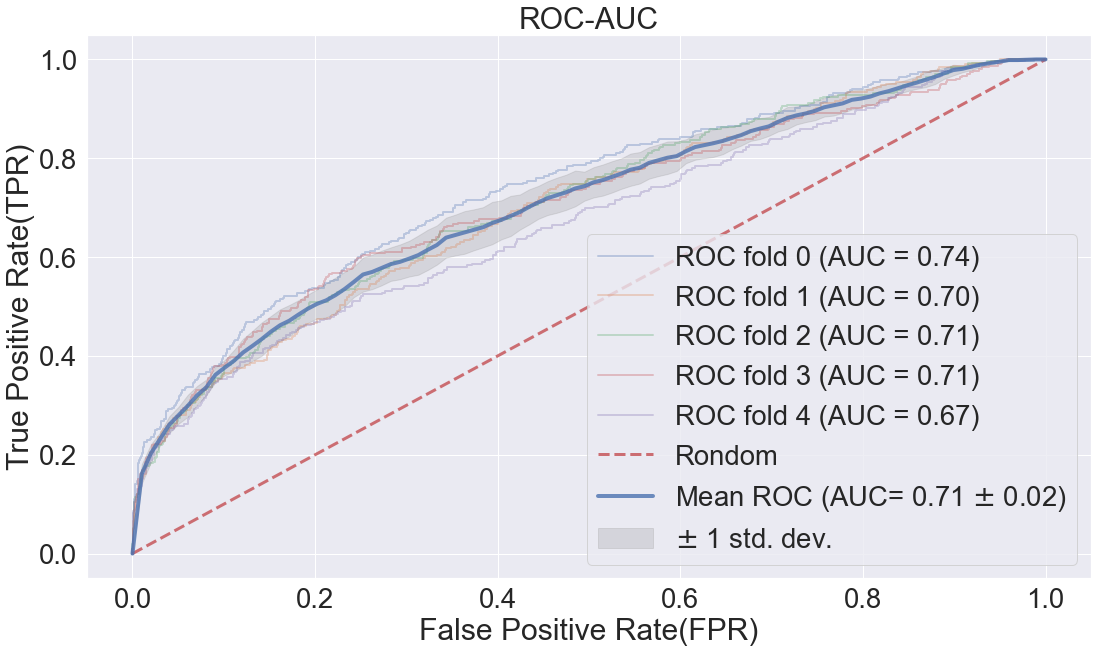

In [23]:
plot_roc_curve(fprs,tprs)
plt.show()

### Grid search with cross validation

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
param_grid={'subsample':[0.7],
'scale_pos_weight':[1],
'n_estimators':[1100],
'min_child_weight':[1],
'max_depth':[12,13,14],
'learning_rate':[0.005,0.01],
'gamma':[4.0],
'colsample_bytree':[0.6]}

In [26]:
xg=xgb.XGBClassifier(objective='binary:logistic',eval_metric='mlogloss')

In [27]:
grid_search=GridSearchCV(estimator=xg,param_grid=param_grid,
                            cv=5,n_jobs= -1,verbose=2,scoring='roc_auc')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 19.0min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
   

In [28]:
best_grid=grid_search.best_params_
best_grid

{'colsample_bytree': 0.6,
 'gamma': 4.0,
 'learning_rate': 0.005,
 'max_depth': 14,
 'min_child_weight': 1,
 'n_estimators': 1100,
 'scale_pos_weight': 1,
 'subsample': 0.7}

In [29]:
model_grid=xgb.XGBClassifier(objective='binary:logistic',
                            nthread=1,eval_metric='mlogloss',**best_grid)
                              
fprs,tprs,score=[],[],[]

In [30]:
for (train,test), i in zip(cv.split(X,y),range(5)):
    model_grid.fit(X.iloc[train],y.iloc[train])
    _,_,auc_score_train=compute_roc_auc(model_grid,train)
    fpr,tpr,auc_score=compute_roc_auc(model_grid,test)
    score.append((auc_score_train,auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

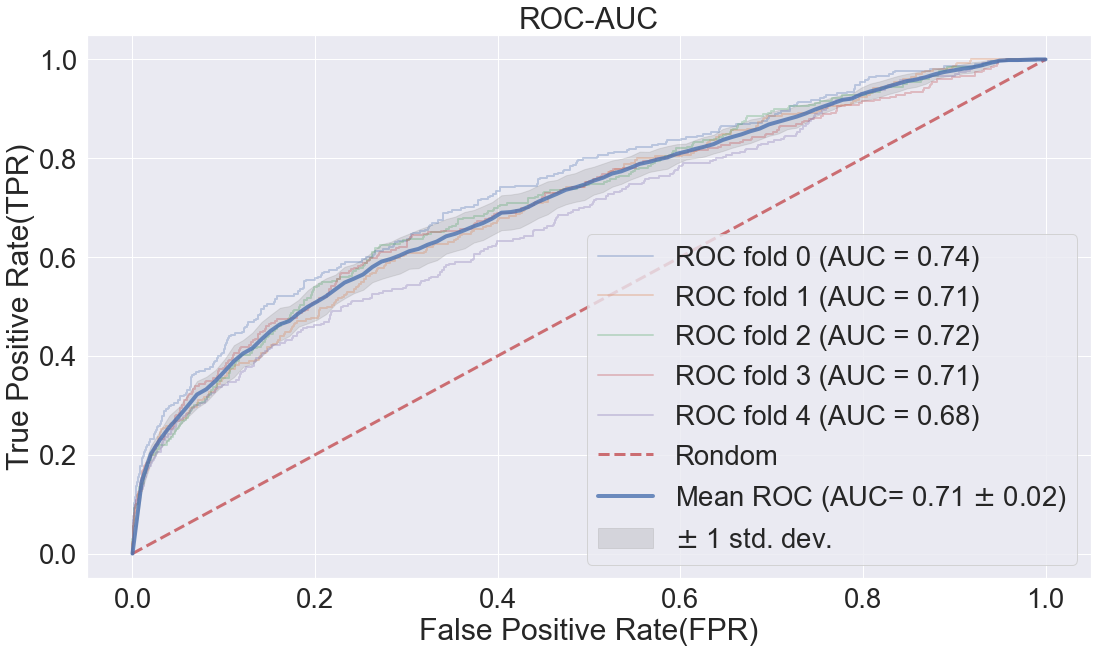

In [31]:
plot_roc_curve(fprs,tprs)
plt.show()

## Understanding the model

### Feature importance

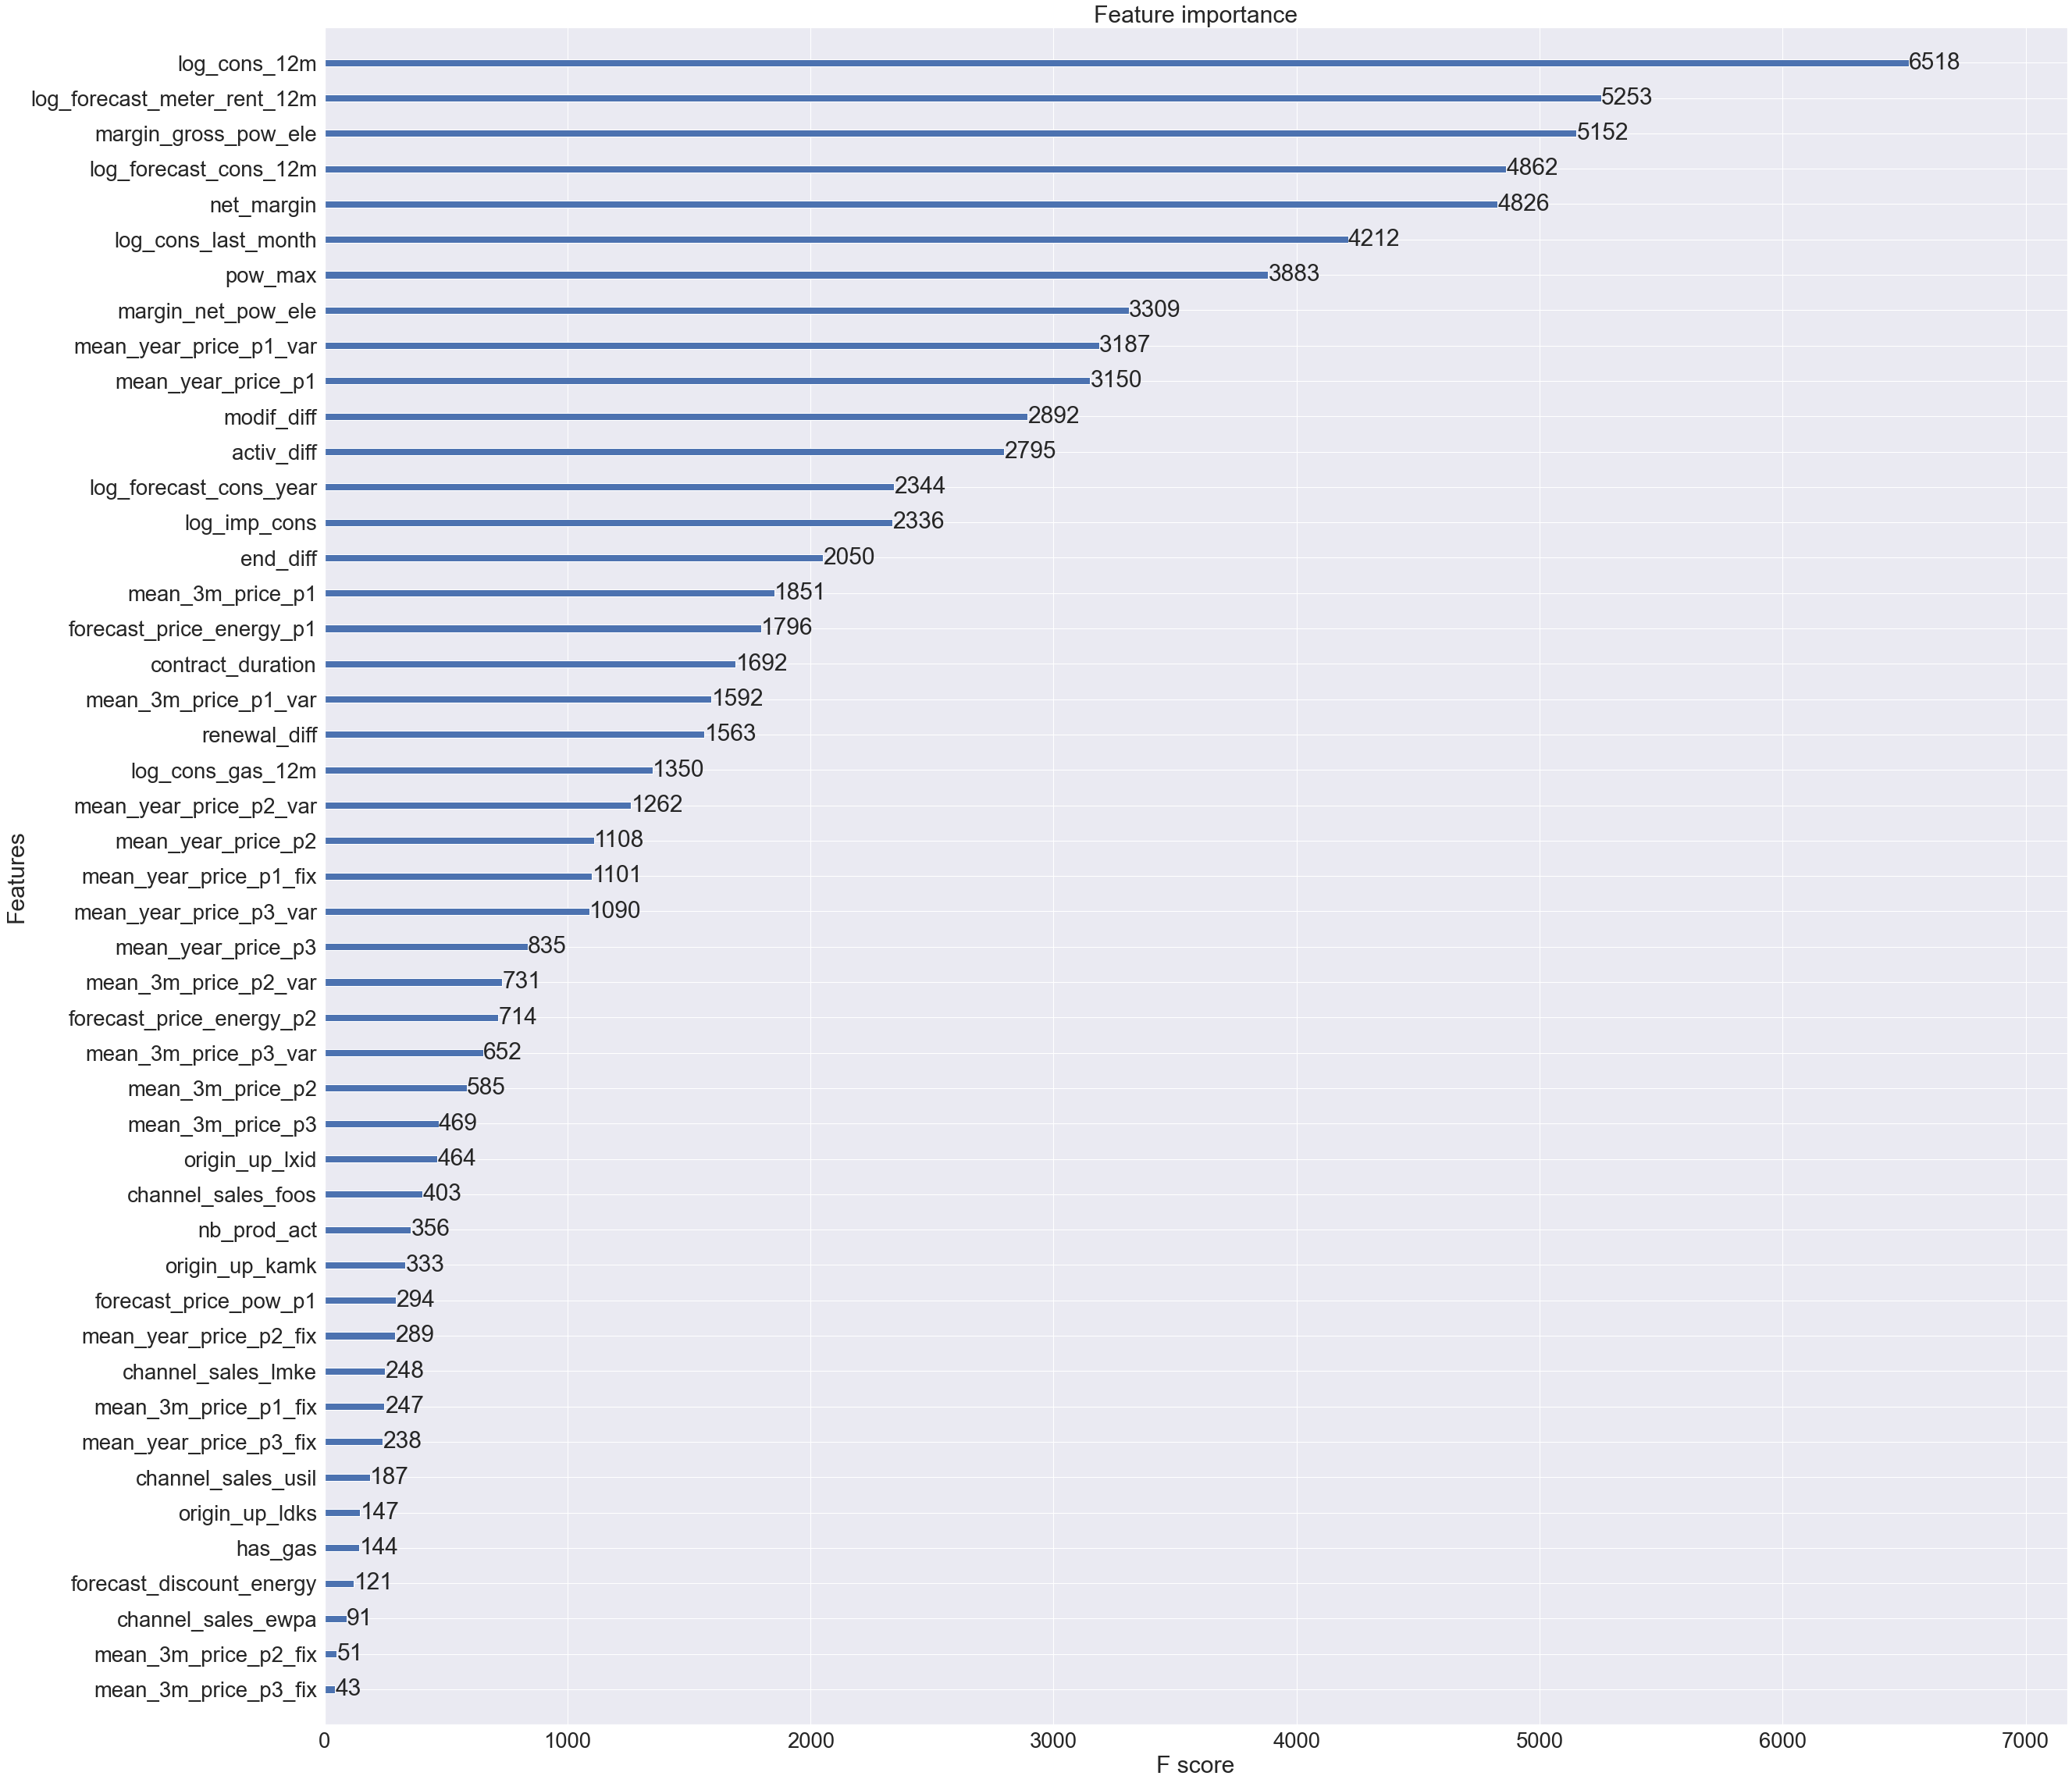

In [32]:
fig,ax=plt.subplots()
fig.set_size_inches(40, 40)
xgb.plot_importance(model_grid,ax=ax);

### Partial dependence plot 

In [33]:
from sklearn.inspection import plot_partial_dependence

In [34]:
model_grid_v2=xgb.XGBClassifier(objective='binary:logistic',
                               eval_metric='mlogloss',nthread=1,**best_grid)
model_grid_v2.fit(X_train.values,y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='mlogloss',
              gamma=4.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.005, max_delta_step=0,
              max_depth=14, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1100, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

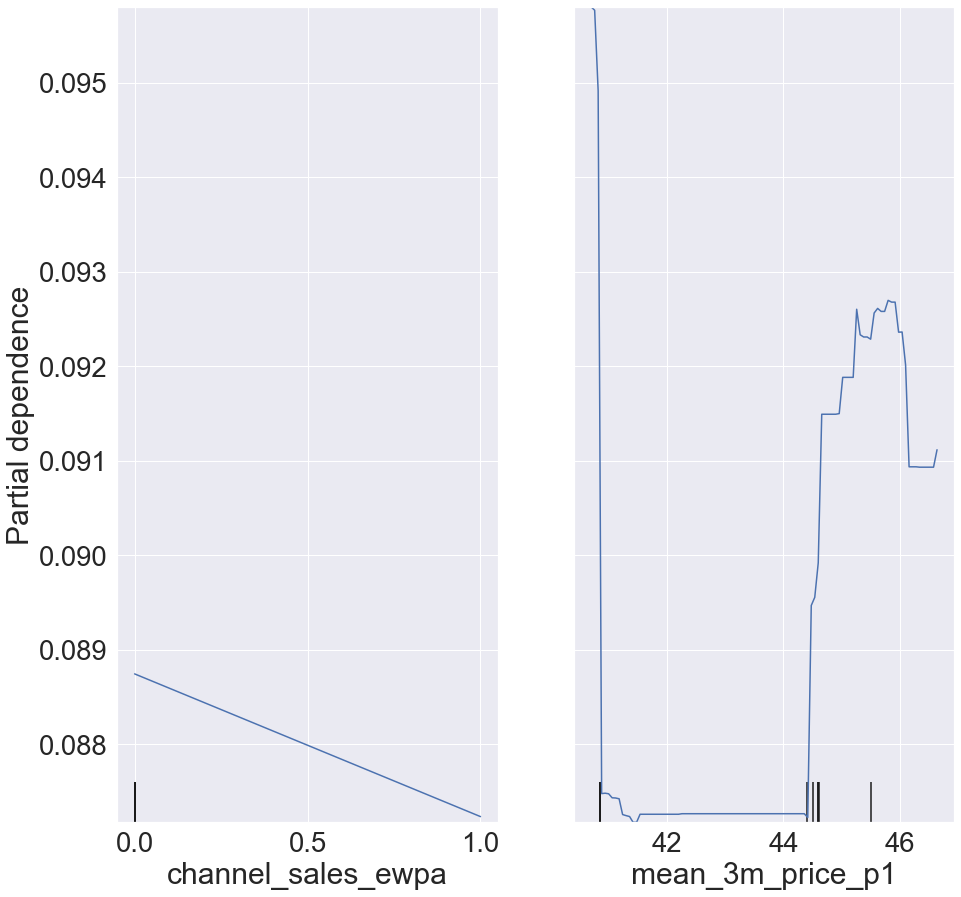

In [35]:
fig=plt.figure(figsize=(15,15))
plot_partial_dependence(model_grid_v2,X_test.values,features=[16,49],feature_names=X_test.columns.tolist(),fig=fig)

## SHAP Feature importance

In [36]:
import shap
explainer=shap.TreeExplainer(model_grid)
shap_values=explainer.shap_values(X_test)

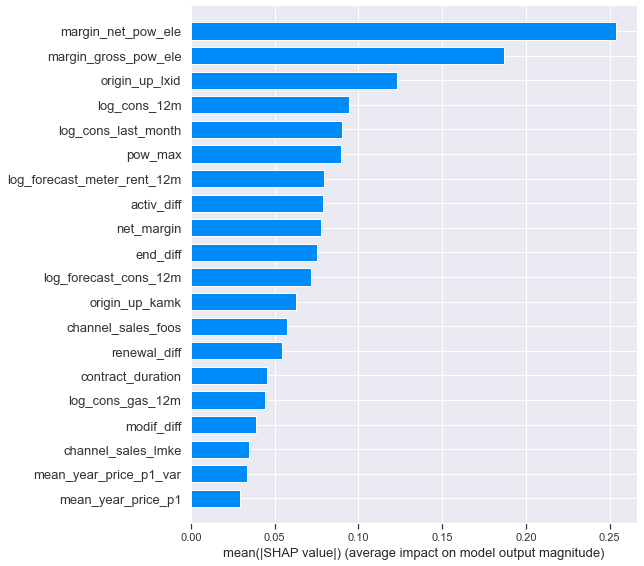

In [37]:
#Feature importance
shap.summary_plot(shap_values,X_test,plot_type='bar')

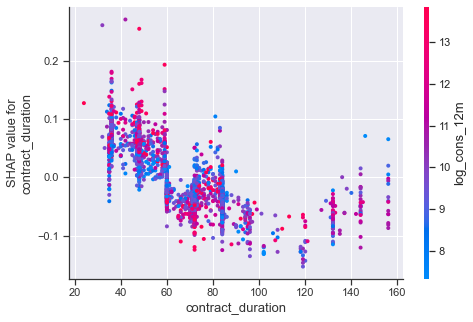

In [38]:
#Partial dependence plot
shap.dependence_plot('contract_duration',shap_values,X_test)


### SHAP Single prediction

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[3171], X_test.iloc[3171,:],link='logit')